In [1]:
!pip install numpyro --quiet
!pip install arviz --quiet

In [2]:
import matplotlib.pyplot as plt

import numpy as onp

import numpyro
from numpyro import sample
from numpyro.infer import MCMC, NUTS, Predictive
import numpyro.distributions as dist
from numpyro.contrib.control_flow import scan
from numpyro.infer.reparam import TransformReparam
from numpyro.handlers import seed

import arviz as az

from tqdm import trange

from jax import random, jit, vmap
import jax.numpy as np

from functools import partial

from scipy.special import logit, expit

import matplotlib.dates as mdates
key = random.PRNGKey(0)


# Line of best fit. Probabilistic approach

In [3]:
N_train = 100

c_exact = 0.
m_exact = 1.
sigma_exact = .3

x = np.linspace(-1, 1, N_train)
y = m_exact*x + c_exact + random.normal(key, x.shape)*sigma_exact

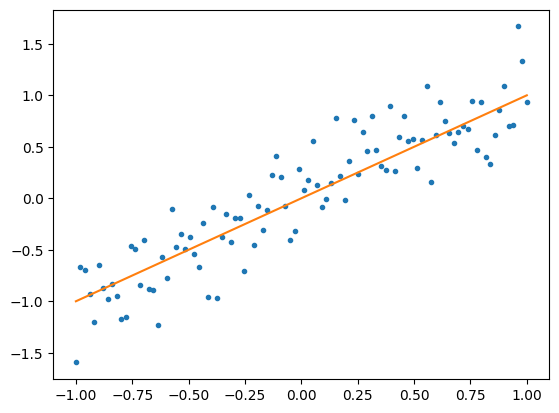

In [4]:
plt.plot(x,y, '.')
plt.plot(x,x, '-');

Let's formulate the problem of fiting the line through the data probabilistically. 

$$
y = mx+c+\varepsilon, \; \varepsilon\sim\mathcal{N}(0,\sigma^2)
$$

We can rewrite the above equivalently as

$$
y\sim\mathcal{N}(mx+c, \sigma^2)
$$

This allows us to **interpret the model generatively:**


0. Either fix noise $\sigma$, or choose a "sensible" random value
1. Choose "sensible" random $m$ and $c$
2. Draw $y$ from the distribution above for each $x$ and the fixed parameters

Why is this view beneficial? 

Because we can reason about $m$ and $c$ if we see a realisation from the generative process. 

This is done with the help of **Bayes theorem:**

We are really drawing $y$ from a parametrised distribution:
$$
y\sim P(y\mid m, c, \sigma),
$$

Bayes allows us to "invert" the distribution: if we see $y$, we can find the joint probability density of $m, c, \sigma$:

$$
P(m, c, \sigma \mid x, y)=\frac{P(y\mid m, c, \sigma)P(m, c, \sigma)}{\textrm{Const}}
$$


**The expression above is the answer to the fitting problem** 

Just sample the parameters $m, c, \sigma$, which are consistent with your data!

*Side note:*
This probabilistic view is more general than optimisation-based methods. It can be shown, that specific popular methods, e.g. least squares/regularised least squares, correspond to the specific choice of the prior distributions and the requirement to maximise the likelihood/posterior. 

It is possible to write the model by naturally reasoning about the generation process as we did above using words. 

In [5]:
def model(x, y=None):
    # Model function describes the joint distribution of data and parameters.
    # This is done by way of declaratively encoding the data generation process. 
    
    # sensible noise scale: it should be positive
    sigma = numpyro.sample("sigma", dist.Exponential(1.0))
    
    # sensible parameters: somewhere not far from zero 
    m = numpyro.sample("m", dist.Normal())
    c = numpyro.sample("c", dist.Normal())
    
    # likelihood model
    mu = m*x+c
    return sample("obs", dist.Normal(mu, sigma), obs = y)

In [17]:
# numpyro.render_model(model, model_args=(x,y))

# Generation

We can generate a data set by running model forward

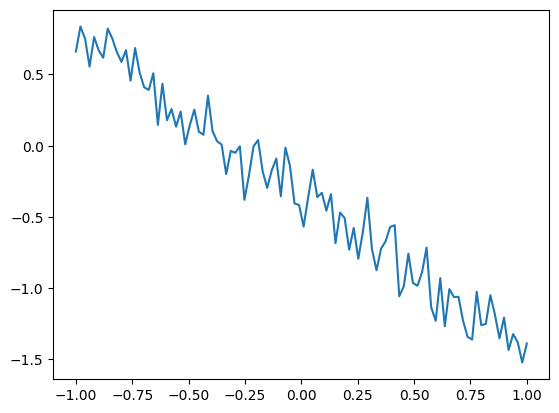

In [7]:
rng_seed = 1
with numpyro.handlers.seed(rng_seed = rng_seed):
    a = model(x, None)

plt.plot(x, a);

# Inference

Think about "inverting" the data generation process: we have data to hand. What were the parameters? 

Crucially, we treat the parameters as distributions. 

Now let's sample from the posterior, conditioning the model on observations

In [8]:
key, _ = random.split(key)
kernel = NUTS(model, max_tree_depth=10, dense_mass=False)
mcmc = MCMC(
    kernel,
    num_warmup=500,
    num_samples=1000,
    num_chains=1,
    progress_bar=True,
)

In [9]:
mcmc.run(key, x, y)

sample: 100%|██████████| 1500/1500 [00:03<00:00, 375.18it/s, 3 steps of size 7.65e-01. acc. prob=0.93]


In [10]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         c      0.02      0.03      0.02     -0.02      0.08    689.81      1.00
         m      1.04      0.05      1.04      0.96      1.12   1027.53      1.00
     sigma      0.29      0.02      0.29      0.26      0.32    818.24      1.00

Number of divergences: 0


**Review our sampling statistics to sanity-check it**

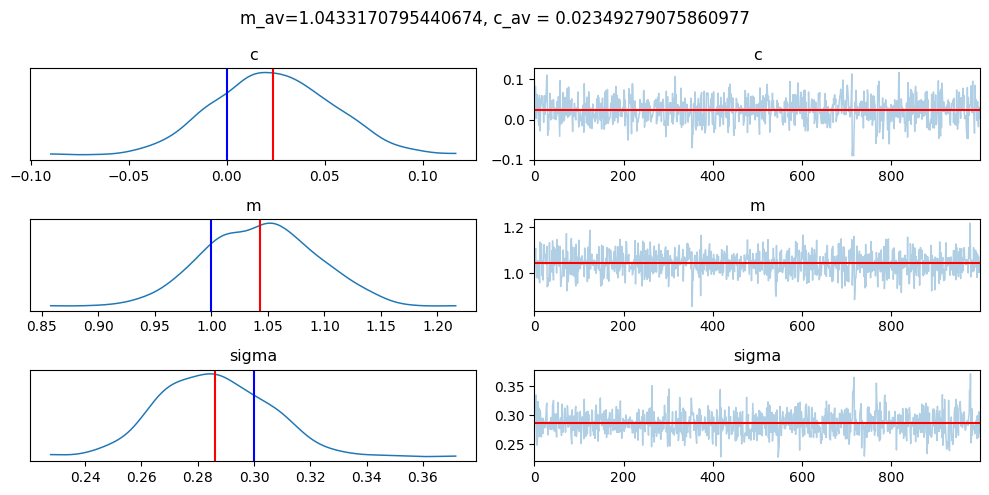

In [11]:
data = az.from_numpyro(mcmc)

m_av1 = mcmc.get_samples()['m'].mean()
c_av1 = mcmc.get_samples()['c'].mean()
sigma_av1 = mcmc.get_samples()['sigma'].mean()

fig, ax = plt.subplots(3,2, figsize = (10, 5))
ax = az.plot_trace(data, axes = ax);

ax[0,0].axvline(c_av1, color = 'r')
ax[0,0].axvline(c_exact, color = 'b')
ax[0,1].axhline(c_av1, color = 'r')

ax[1,0].axvline(m_av1, color = 'r')
ax[1,0].axvline(m_exact, color = 'b')
ax[1,1].axhline(m_av1, color = 'r');

ax[2,0].axvline(sigma_av1, color = 'r');
ax[2,0].axvline(sigma_exact, color = 'b')
ax[2,1].axhline(sigma_av1, color = 'r');


fig.suptitle(f'm_av={m_av1}, c_av = {c_av1}')

fig.tight_layout();

# Consistent fits

We got possible linear fits. 

**Notice:** with this approach we get uncertainty quantication: how sure is our model about its own predictions. The more training data we have, the more sure the model will be. Try running again with more/less training data and observe the contraction of posterior!

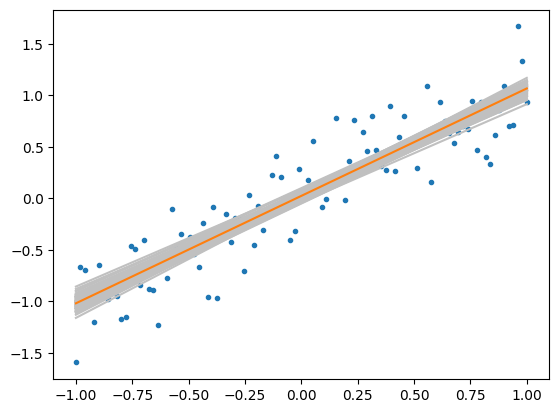

In [12]:
plt.plot(x,y,'.')
plt.plot(x, 
         mcmc.get_samples()['m'][::10]*x[:,None]+mcmc.get_samples()['c'][::10], 
         color ='silver');
plt.plot(x, mcmc.get_samples()['m'].mean()*x+mcmc.get_samples()['c'].mean());

# Run model generatively: What training data "could" have looked like

We assume that we see only a subset of data. Based on what we see, we can infer the model parameters, and then generate more data. This is an important property of probabilistic models!

In [13]:
predictive = numpyro.infer.Predictive(model, mcmc.get_samples(), num_samples = 1000)

In [14]:
y1 = predictive(key, x)

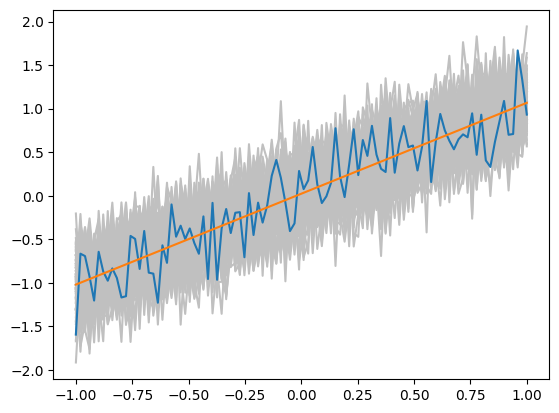

In [15]:
plt.plot(x, y1['obs'][::10].T, color = 'silver');
plt.plot(x,y )
plt.plot(x, mcmc.get_samples()['m'].mean()*x+mcmc.get_samples()['c'].mean());